<a href="https://colab.research.google.com/github/Llmortimer/character_morality/blob/main/PreprocessingSplitAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y espeak espeak-data libespeak1 libespeak-dev
!apt-get install -y --force-yes ffmpeg
!apt-get install -y --force-yes deb-multimedia-keyring
!apt-get install -y festival*
!apt-get install -y build-essential
!apt-get install -y flac libasound2-dev libsndfile1-dev vorbis-tools
!apt-get install -y libxml2-dev libxslt-dev zlib1g-dev
!apt-get install -y python-dev python-pip

!pip install numpy
!pip install ffmpeg-python
!pip install python-espeak
!pip install aeneas
!pip install ffmpy

!pip install matplotlib
!pip install simplejson
!pip install scipy
!pip install hmmlearn
!pip install eyeD3
!pip install pydub
!pip install scikit_learn
!pip install tqdm
!pip install plotly
!pip install pandas
!pip install pyAudioAnalysis
!pip install pickle5
!pip install cloudpickle
# !pip install noisereduce

In [ ]:
!export PYTHONPATH=$PYTHONPATH:"/usr/local/lib/python3.7/dist-packages/pyAudioAnalysis"
!source ~/.bashrc

from aeneas.executetask import ExecuteTask
from aeneas.task import Task
from ffmpy import FFmpeg
import re
# coding=utf-8    

from aeneas.exacttiming import TimeValue
from aeneas.language import Language
from aeneas.syncmap import SyncMapFormat
from aeneas.task import TaskConfiguration
from aeneas.textfile import TextFileFormat
from aeneas.runtimeconfiguration import RuntimeConfiguration
import aeneas.globalconstants as gc

from pydub import AudioSegment as pAS 
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
from pyAudioAnalysis import audioTrainTest as aT
import matplotlib.pyplot as plt

import collections
import json

import os
import subprocess

from natsort import natsorted, ns

# import noisereduce as nr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_video = "/content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeFilm.mp4"
output_ts = "/content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeScenes.txt"

input_script = "/content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeScript.txt"
dialogue_script = "/content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeDialogue.txt"

output_audio = "/content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeAudio.mp4"
voice_audio = "/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated.mp3"

sync_map = "/content/drive/MyDrive/shared/Scripts_and_Films/syncmap.jason"

In [ ]:
#pre-process script by extracting the dialogue and character names writing to seperate file.
f = open(input_script).read()
matches = re.findall(r"\n\s+([A-Z ]+)\n *((.+\s)*)", f, re.M)
dialogue = []
characters = []
for i in matches:
    if '' not in i:
        dialogue.append(" ".join(i[1].split()) + "\n\n")
        characters.append(i[0])


with open(dialogue_script, "w") as ds:
    for inst in dialogue:
        ds.write(inst)

In [ ]:
# copy audio from video to seperate file.
# will fail if the output file already exists (not isolated version)
ff = FFmpeg(
    inputs = {input_video: None},
    outputs = {output_audio: '-vn -acodec copy'}
)
ff.cmd
ff.run()

(None, None)

In [ ]:
#scene detection, for each frame assign a probablility that the scene has changed given the change of intensity of the pixels on the pervious frame.
#if this probablility is higher than 0.5 for a given frame the frame time, and probablilty have been output to a file "time.txt" and the frame itself output to a PNG in scenes/ 

!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/IndianaLastCrusadeFilm.mp4 -filter_complex "select='gt(scene,0.5)',metadata=print:file=/content/drive/MyDrive/shared/scenes/time.txt" -vsync vfr /content/drive/MyDrive/shared/scenes/img%03d.png


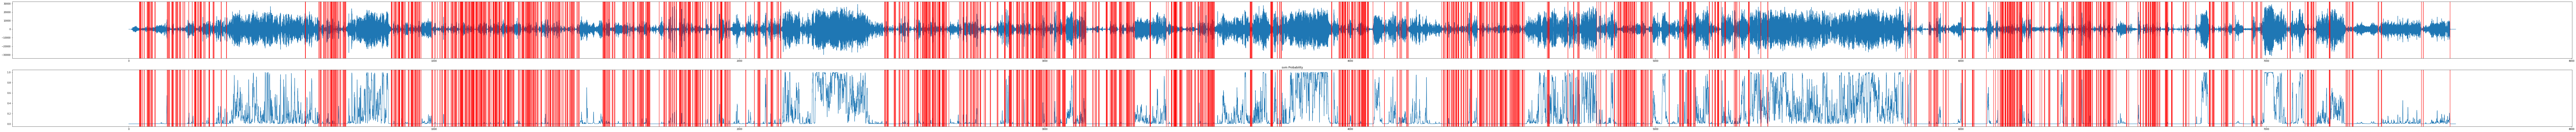

In [ ]:
[Fs, x] = aIO.read_audio_file(voice_audio)
plt.figure(figsize=(200, 10))
segments = aS.silence_removal(x, Fs, 0.02, 0.02, smooth_window = 1, weight = 0.001 , plot=True)
Fs = 0
x = 0

In [ ]:
print(len(segments))
print(segments)

1127
[[91.4, 91.62], [103.60000000000001, 104.0], [104.48, 105.12], [105.44, 106.48], [107.78, 108.86], [112.52, 113.22], [124.34, 125.72], [132.78, 133.26], [146.3, 146.74], [193.52, 194.02], [195.72, 196.38], [197.12, 198.06], [198.78, 199.24], [202.9, 203.3], [205.06, 205.6], [205.8, 207.42000000000002], [209.3, 209.56], [209.66, 211.9], [212.26, 212.8], [242.34, 242.9], [254.14000000000001, 255.74], [257.82, 258.22], [259.08, 259.62], [259.8, 260.48], [260.86, 261.34000000000003], [261.62, 262.2], [262.92, 263.84000000000003], [274.28000000000003, 274.76], [280.94, 281.28000000000003], [282.12, 282.44], [285.8, 286.46], [287.94, 288.82], [291.58, 294.34000000000003], [294.54, 295.98], [297.34000000000003, 301.14], [301.34000000000003, 302.14], [305.24, 307.36], [307.68, 308.1], [308.24, 308.84000000000003], [309.3, 310.14], [314.38, 315.78000000000003], [316.7, 317.98], [321.08, 322.66], [324.42, 324.84000000000003], [327.06, 327.58], [328.74, 330.48], [330.72, 331.28000000000003],

In [ ]:
#remove the silence in the audio file generating a new .wav file for each segment with detected audio
!python /usr/local/lib/python3.7/dist-packages/pyAudioAnalysis/audioAnalysis.py silenceRemoval -i /content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated.mp3 --smoothing 1 --weight 0.001



tcmalloc: large alloc 2926272512 bytes == 0x564ffbc04000 @  0x7f9d3b1f81e7 0x7f9d38a090ce 0x7f9d38a63726 0x7f9d38a63b09 0x7f9d38a65620 0x7f9d38b36704 0x564f6b000675 0x564f6afc0b32 0x564f6b034a6d 0x564f6b02f02f 0x564f6afc1aba 0x564f6b0342c0 0x564f6b02f02f 0x564f6afc1aba 0x564f6b0342c0 0x564f6afc19da 0x564f6b02feae 0x564f6b02f02f 0x564f6b02ed43 0x564f6b0f9302 0x564f6b0f967d 0x564f6b0f9526 0x564f6b0d11d3 0x564f6b0d0e7c 0x7f9d39fe2c87 0x564f6b0d0d5a
tcmalloc: large alloc 2926272512 bytes == 0x5650d654e000 @  0x7f9d3b1f81e7 0x7f9d38a090ce 0x7f9d38a5fcf5 0x7f9d38a5fe08 0x7f9d38ca9a50 0x7f9d38ca9e10 0x564f6afc1600 0x564f6afc11d9 0x7f9d38b298a3 0x564f6afa3883 0x564f6b0ab1a6 0x564f6b031e92 0x564f6b02f02f 0x564f6afc1aba 0x564f6b0342c0 0x564f6b02f02f 0x564f6afc1aba 0x564f6b0342c0 0x564f6afc19da 0x564f6b02feae 0x564f6b02f02f 0x564f6b02ed43 0x564f6b0f9302 0x564f6b0f967d 0x564f6b0f9526 0x564f6b0d11d3 0x564f6b0d0e7c 0x7f9d39fe2c87 0x564f6b0d0d5a
tcmalloc: large alloc 2926272512 bytes == 0x564ffbc0400

In [ ]:
#combine the generated .wav files into a single chronological file
combined = pAS.empty()

for f in os.listdir("/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/"):
    if f.endswith(".wav"):
        seg = pAS.from_wav("/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/"+f)
        combined += seg

combined.export("/content/drive/MyDrive/shared/Scripts_and_Films/RemovedSilence.wav", format="wav")

In [ ]:
#convert pickle protocol 5 to protocol 4 to make it compatable with this version of python
#classify all generated files from the silence detection to determine if each one is music or speech using a pre-trained SVM
import pickle5 as pkl
import pandas as pd

with (open("/content/drive/MyDrive/shared/svm_rbf_smMEANS", "rb")) as fo:
    mean = pkl.load(fo)
    std = pkl.load(fo)
    classNames = pkl.load(fo)
    mid_window = pkl.load(fo)
    mid_step = pkl.load(fo)
    short_window = pkl.load(fo)
    short_step = pkl.load(fo)
    compute_beat = pkl.load(fo)

with open("/content/drive/MyDrive/shared/svm_rbf_sm2MEANS", 'wb') as f:
    pkl.dump(mean, f, protocol=4)
    pkl.dump(std, f, protocol=4)
    pkl.dump(classNames, f, protocol=4)
    pkl.dump(mid_window, f, protocol=4)
    pkl.dump(mid_step, f, protocol=4)
    pkl.dump(short_window, f, protocol=4)
    pkl.dump(short_step, f, protocol=4)
    pkl.dump(compute_beat, f, protocol=4)

with (open("/content/drive/MyDrive/shared/svm_rbf_sm", "rb")) as fo:
    svm = pkl.load(fo)

with open("/content/drive/MyDrive/shared/svm_rbf_sm2", 'wb') as f:
    pkl.dump(svm, f, protocol=4)

# [flagsInd, classesAll, acc, CM] = audioAnalysis.classifyFileWrapper(voice_audio, "/content/drive/MyDrive/shared/svm_rbf_sm2", "svm", True)

!python /usr/local/lib/python3.7/dist-packages/pyAudioAnalysis/audioAnalysis.py classifyFolder -i /content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_ --model svm --classifier /content/drive/MyDrive/shared/svm_rbf_sm2 --details > /content/drive/MyDrive/shared/Scripts_and_Films/smClassifierOutput.txt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [11]:
speech_segments = []

with open("/content/drive/MyDrive/shared/Scripts_and_Films/smClassifierOutput.txt") as f:
    for line in f:
        if line.endswith("\tspeech\n"):
            line = line[:-8]
            speech_segments.append(line)
        
    sorted = natsorted(speech_segments)
    print(sorted)

combined = pAS.empty()

for f in sorted:
    seg = pAS.from_wav(f)
    combined += seg

combined.export("/content/drive/MyDrive/shared/Scripts_and_Films/RemovedSilenceSpeechOnly.wav", format="wav")


['/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_9.500-10.400.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_18.600-19.550.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_20.750-21.750.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_129.350-130.300.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_131.700-133.950.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_141.000-142.050.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_144.550-147.150.wav', '/content/drive/MyDrive/shared/Scripts_and_Films/Silence_Detection/IndianaLastCrusadeAudioIsolated_157.600-158.700.wav', '/content/drive/MyDrive/shared/Scripts

<_io.BufferedRandom name='/content/drive/MyDrive/shared/Scripts_and_Films/RemovedSilenceSpeechOnly.wav'>

In [ ]:
rconf = RuntimeConfiguration()

rconf[RuntimeConfiguration.MFCC_MASK_NONSPEECH] = True
rconf[RuntimeConfiguration.MFCC_MASK_NONSPEECH_L1] = True
# rconf[RuntimeConfiguration.MFCC_WINDOW_LENGTH_L1] = TimeValue(u"0.8")
# rconf[RuntimeConfiguration.MFCC_WINDOW_SHIFT_L1] = TimeValue(u"0.25")
# rconf[RuntimeConfiguration.MFCC_MASK_NONSPEECH_L2] = True
# rconf[RuntimeConfiguration.MFCC_MASK_NONSPEECH_L3] = True
rconf[RuntimeConfiguration.MFCC_MASK_LOG_ENERGY_THRESHOLD] = TimeValue(u"0.8")

rconf[RuntimeConfiguration.TTS] = 'festival'

rconf[RuntimeConfiguration.DTW_MARGIN] = 30

rconf[RuntimeConfiguration.VAD_MIN_NONSPEECH_LENGTH] = TimeValue(u"0.01")
# rconf[RuntimeConfiguration.VAD_LOG_ENERGY_THRESHOLD] = TimeValue(u"1")

config_string = u"task_language=eng|is_text_type=mplain|os_task_file_format=json|os_task_file_levels=1|is_audio_file_head_length=115|is_audio_file_tail_length=405|task_adjust_boundary_nonspeech_min=0.01|task_adjust_boundary_nonspeech_string=REMOVE"
#|task_adjust_boundary_algorithm=percent|task_adjust_boundary_percent_value=50
task = Task(config_string=config_string, rconf=rconf)
task.audio_file_path_absolute = voice_audio
task.text_file_path_absolute = dialogue_script
task.sync_map_file_path_absolute = sync_map

In [ ]:
ExecuteTask(task).execute()
print(task.sync_map)
task.output_sync_map_file()


In [ ]:
occurances = collections.Counter(characters)
print(occurances)

Counter({'INDY': 328, 'HENRY': 147, 'ELSA': 74, 'DONOVAN': 59, 'BRODY': 58, 'SALLAH': 28, 'VOGEL': 26, 'FEDORA': 12, 'KAZIM': 12, 'ROSCOE': 8, 'KNIGHT': 8, 'HERMAN': 5, 'PANAMA HAT': 5, 'SHERIFF': 5, 'BUTLER': 4, 'SULTAN': 4, 'HALFBREED': 3, 'SINISTER MAN': 3, 'NAZI SOLDIER': 3, 'MAN': 2, 'IRENE': 2, 'WOMAN': 2, 'OFFICER': 1, 'FIRST SCOUT': 1, 'SCOUTMASTER': 1, 'MEN': 1, 'ROUGH RIDER': 1, 'MALE STUDENT': 1, 'MAN IN CHAIR': 1, 'SECOND MAN': 1, 'LIEUTENANT': 1, 'RADIO OPERATOR': 1, 'GUARD': 1, 'FEMALE PASSENGER': 1, 'MALE PASSENGER': 1, 'PERISCOPE SOLDIER': 1})


In [ ]:
f = open("../Scripts_and_Films/syncmap.jason", "r")
data = json.load(f)


for count, dialogue in enumerate(data["fragments"]):
    print(characters[count] + ": " + dialogue["lines"][0] + " - duration: {:.3f}s -".format(float(dialogue["end"])-float(dialogue["begin"])) + " start: {:.3f}s -".format(float(dialogue["begin"]))  + " end: {:.3f}s".format(float(dialogue["end"])))

OFFICER: Dis-mount! - duration: 0.840s - start: 117.000s - end: 117.840s
FIRST SCOUT: Herman's horsesick! - duration: 1.920s - start: 117.840s - end: 119.760s
SCOUTMASTER: Chaps, don't anybody wander off. Some of the passageways in here can run for miles. - duration: 22.920s - start: 119.760s - end: 142.680s
HERMAN: I don't think this is such a good idea. - duration: 15.440s - start: 142.680s - end: 158.120s
HERMAN: What is it? - duration: 6.300s - start: 158.120s - end: 164.420s
FEDORA: Alfred, did you get anything yet? - duration: 26.160s - start: 165.240s - end: 191.400s
MAN: Nothing. Dig in. - duration: 2.360s - start: 191.400s - end: 193.760s
ROSCOE: Hey, I've got something! - duration: 5.800s - start: 193.760s - end: 199.560s
ROSCOE: I got something, Garth! - duration: 11.360s - start: 199.560s - end: 210.920s
ROSCOE: I got something... I got something right here. - duration: 7.480s - start: 210.920s - end: 218.400s
ROSCOE: (more whoops; then) Oh, look at that! (more whoops) We'r

In [ ]:
matches = []
with open("../Python_Scripts/time.txt") as file:
    for line in file:
        match = re.match(".*(?<=pts_time:)([0-9.]+)", line)
        if match:
            matches.append(match.group(1))

filmInfo = []
# for count, i in enumerate(matches):
#     if count == len(matches):
#         break
#     sceneInfo[count] = "{:.3f}".format(float(matches[count+1]) - float(i))
i=0
while i < len(matches)-1:
    sceneInfo = {}
    sceneInfo["id"] = i
    sceneInfo["duration"] = "{:.3f}".format(float(matches[i+1]) - float(matches[i]))
    sceneInfo["start"] = "{:.3f}".format(float(matches[i]))
    sceneInfo["end"] = "{:.3f}".format(float(matches[i+1]))
    filmInfo.append(sceneInfo)
    i+=1

for info in filmInfo:
    print(info)


{'id': 0, 'duration': '55.931', 'start': '66.900', 'end': '122.831'}
{'id': 1, 'duration': '6.507', 'start': '122.831', 'end': '129.338'}
{'id': 2, 'duration': '18.602', 'start': '129.338', 'end': '147.940'}
{'id': 3, 'duration': '183.475', 'start': '147.940', 'end': '331.415'}
{'id': 4, 'duration': '5.547', 'start': '331.415', 'end': '336.962'}
{'id': 5, 'duration': '20.312', 'start': '336.962', 'end': '357.274'}
{'id': 6, 'duration': '3.795', 'start': '357.274', 'end': '361.069'}
{'id': 7, 'duration': '1.377', 'start': '361.069', 'end': '362.446'}
{'id': 8, 'duration': '2.252', 'start': '362.446', 'end': '364.698'}
{'id': 9, 'duration': '17.976', 'start': '364.698', 'end': '382.674'}
{'id': 10, 'duration': '83.334', 'start': '382.674', 'end': '466.008'}
{'id': 11, 'duration': '3.336', 'start': '466.008', 'end': '469.344'}
{'id': 12, 'duration': '1.085', 'start': '469.344', 'end': '470.429'}
{'id': 13, 'duration': '1.168', 'start': '470.429', 'end': '471.597'}
{'id': 14, 'duration': '